In [1]:
# Package Imports

# File management
import os

# Data/numeric manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Modelling & Evaluation
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error,make_scorer
from mlxtend.evaluate import feature_importance_permutation
from lime.lime_tabular import LimeTabularExplainer

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
### Load Data

# Read in data
train_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\train.csv')
test_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\test.csv')

In [3]:
# Adjust data
train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')
test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

# Don't MinMax Adjust data
"""scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)
df_test_data_scaled = pd.DataFrame(scaler.fit_transform(test_data_x), columns=test_data_x.columns)"""

# train test val splits
X_data, X_test, y_data, y_test = train_test_split(train_data_x.to_numpy(), train_data_target.to_numpy(), test_size=0.2, random_state=42) # to numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [4]:
### Hyperopt sklearn HP tuning
# Source: https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

# define search
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=190, trial_timeout=30)
# evals = 190
# perform the search
model.fit(X_train, y_train) #Change to lower evals
# summarize performance
acc = model.score(X_val, y_val)
print("Accuracy: %.3f" % acc)
# summarize the best model
print(model.best_model())

100%|████████████████████████████████████████████████████| 190/190 [00:34<00:00, 34.02s/trial, best loss: 0.1845703125]
Accuracy: 0.845
{'learner': RandomForestClassifier(max_features=0.7640161111447819, n_estimators=124,
                       n_jobs=1, random_state=4, verbose=False), 'preprocs': (), 'ex_preprocs': ()}


In [15]:
### HP Tuning Random Forest Classifier with Hyperopt
# Source: https://www.kaggle.com/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt

seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_val)
    score=mean_squared_error(y_val,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=50,rstate=np.random.RandomState(seed)) #max_evals=500
    return best

trial=Trials()
#best=optimize(trial)

100%|████████████████████████████████████████████| 500/500 [1:10:35<00:00,  8.47s/trial, best loss: 0.1205177548455046]


In [16]:
print(best)

{'max_depth': 8.857333102037256, 'min_samples_leaf': 1.2584108003917138, 'min_samples_split': 5.263031441354376, 'n_estimators': 257.42270665919244}


In [17]:
for t in trial.trials[:2]:
    print (t)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.1208891230945162, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [6.44924027262962], 'min_samples_leaf': [3.2557038491408083], 'min_samples_split': [3.705893814587132], 'n_estimators': [310.68170422696016]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 2, 14, 6, 26, 8, 298000), 'refresh_time': datetime.datetime(2021, 2, 14, 6, 26, 13, 886000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 0.12295173308854075, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'min_samples_leaf': [1], 'min_samples_split': [1], 'n_estimators': [1]}, 'vals': {'max_depth': [13.330641077198102], 'min_samples_leaf': [4.1346696482442695], 'min_samples_sp

In [18]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

NameError: name 'sns' is not defined

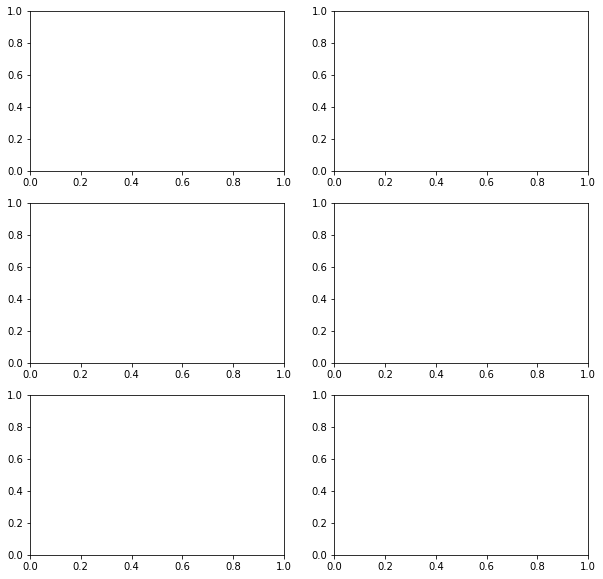

In [19]:
plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()